In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import math
from functions import *
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

%matplotlib inline

In [2]:
data = pd.read_csv('./data/data.csv')

In [3]:
data=data.rename(columns = {"Unnamed: 0": "Date"})
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace = True)
data.sort_index(inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146664 entries, 2003-01-01 00:00:00 to 2019-08-31 23:00:00
Data columns (total 13 columns):
Load             146034 non-null float64
CAPITL           146034 non-null float64
CENTRL           146034 non-null float64
DUNWOD           146034 non-null float64
GENESE           146034 non-null float64
HUD VL           146034 non-null float64
LONGIL           127809 non-null float64
MHK VL           146034 non-null float64
MILLWD           146034 non-null float64
N.Y.C.           127809 non-null float64
NORTH            146034 non-null float64
WEST             146034 non-null float64
N.Y.C._LONGIL    18225 non-null float64
dtypes: float64(13)
memory usage: 15.7 MB


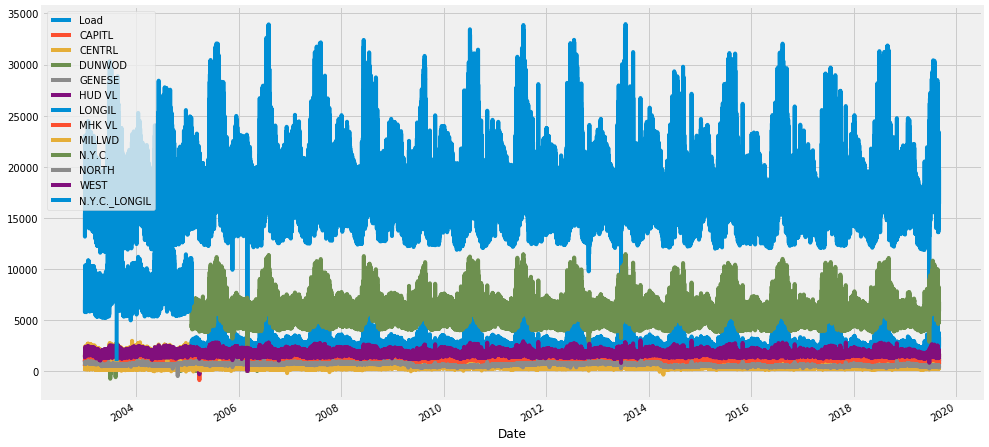

In [5]:
data.plot(kind = 'line', figsize=(15, 8))
plt.show()

In [6]:
#drop NaNs
target = 'Load'
data.dropna(subset = [target], inplace=True)
data.isna().sum()

Load                  0
CAPITL                0
CENTRL                0
DUNWOD                0
GENESE                0
HUD VL                0
LONGIL            18225
MHK VL                0
MILLWD                0
N.Y.C.            18225
NORTH                 0
WEST                  0
N.Y.C._LONGIL    127809
dtype: int64

In [7]:
drop_cols = [col for col in data.columns.tolist() if col not in [target]]
data.drop(drop_cols, axis=1, inplace=True)

In [8]:
data.head()

,Load
Date,
2003-01-01 00:00:00,15415.625000
2003-01-01 01:00:00,14569.928571
2003-01-01 02:00:00,13812.200000
2003-01-01 03:00:00,13315.333333
2003-01-01 04:00:00,13156.333333


In [9]:
data.shape

(146034, 1)

In [33]:
df = data['01-01-2014':'08-31-2019'].copy()

In [92]:
train, test = split_data(data, '01-01-2017')

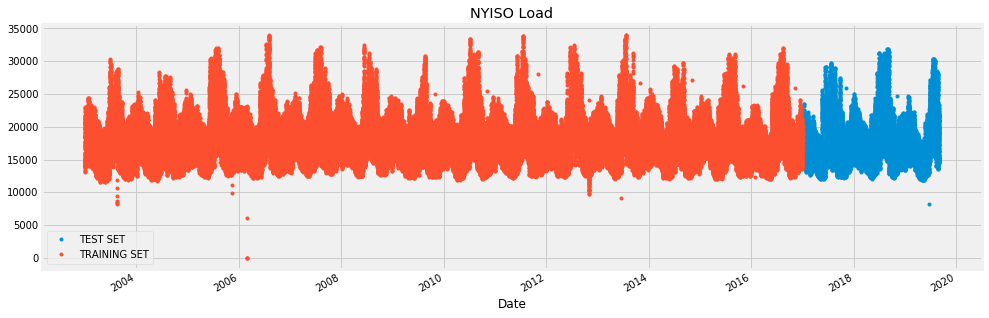

In [93]:
test \
    .rename(columns={target: 'TEST SET'}) \
    .join(train.rename(columns={target: 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='NYISO Load', style='.')

In [94]:
train = train.reset_index().rename(columns={'Date':'ds', target:'y'})
train.head()

,ds,y
0,2003-01-01 00:00:00,15415.625000
1,2003-01-01 01:00:00,14569.928571
2,2003-01-01 02:00:00,13812.200000
3,2003-01-01 03:00:00,13315.333333
4,2003-01-01 04:00:00,13156.333333


In [95]:
# Setup and train model
model = Prophet()
model.fit(train)

In [96]:
test.head()

,Load
Date,
2017-01-01 00:00:00,15763.208333
2017-01-01 01:00:00,15071.408333
2017-01-01 02:00:00,14485.033333
2017-01-01 03:00:00,14097.658333
2017-01-01 04:00:00,13937.300000


In [97]:
test_=test.reset_index().rename(columns={'Date':'ds'})

In [98]:
test_['ds'].head()

0   2017-01-01 00:00:00
1   2017-01-01 01:00:00
2   2017-01-01 02:00:00
3   2017-01-01 03:00:00
4   2017-01-01 04:00:00
Name: ds, dtype: datetime64[ns]

In [99]:
test_fcst = model.predict(test_)

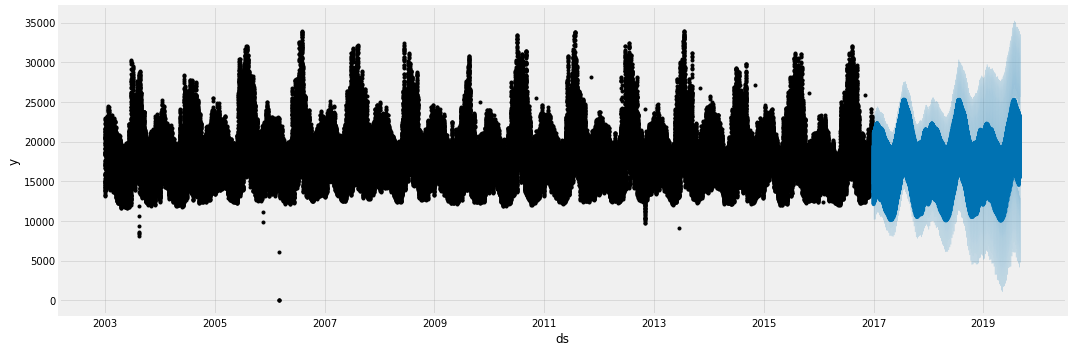

In [100]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst, ax=ax)

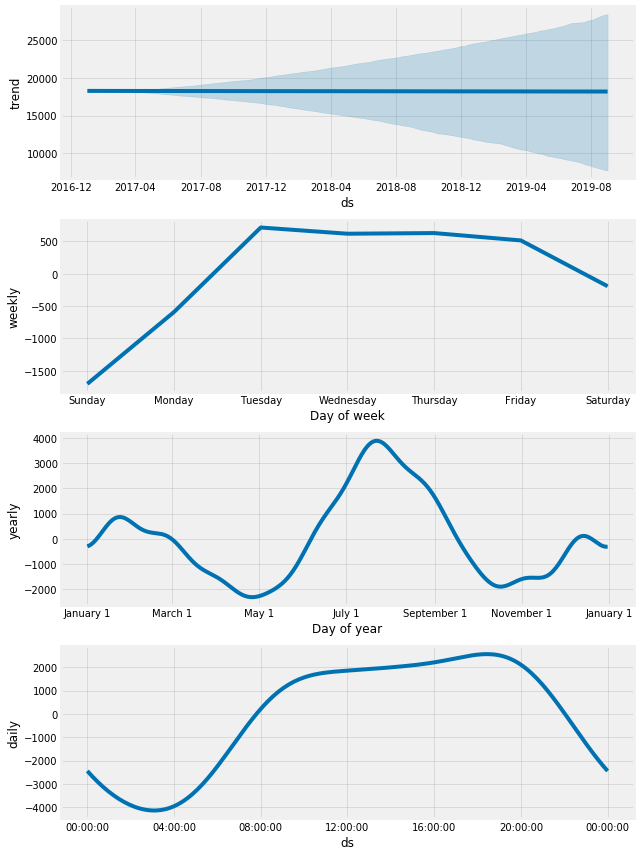

In [107]:
fig = model.plot_components(test_fcst)

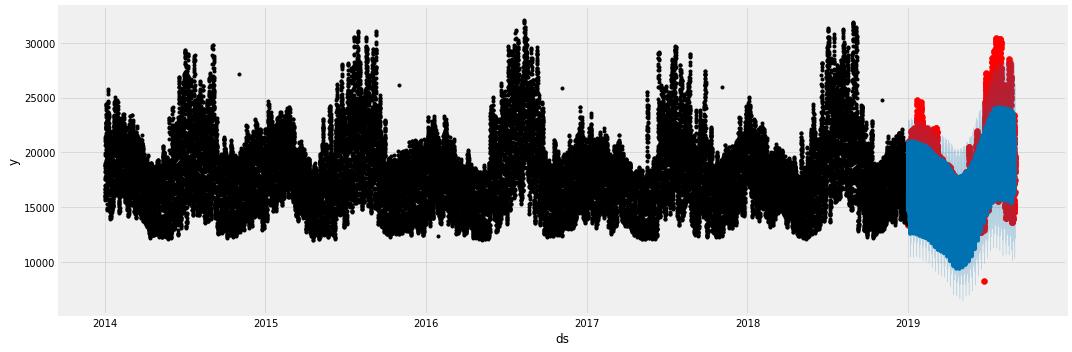

In [45]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)

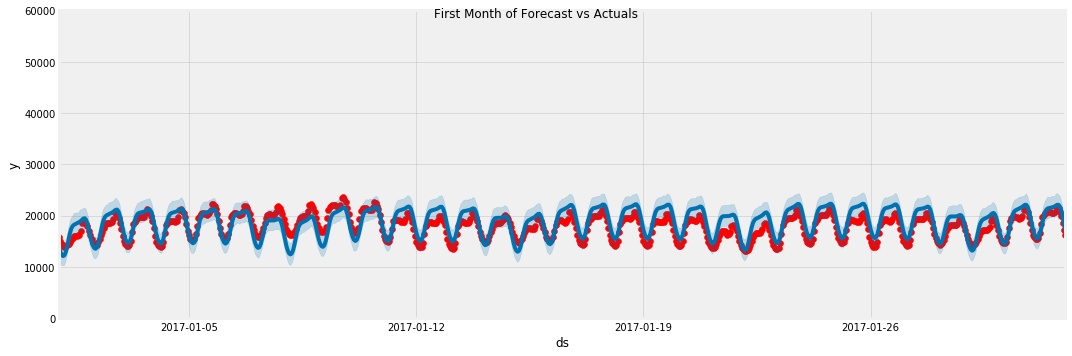

In [101]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(test.index[0], upper=test.index[(24*31)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Month of Forecast vs Actuals')

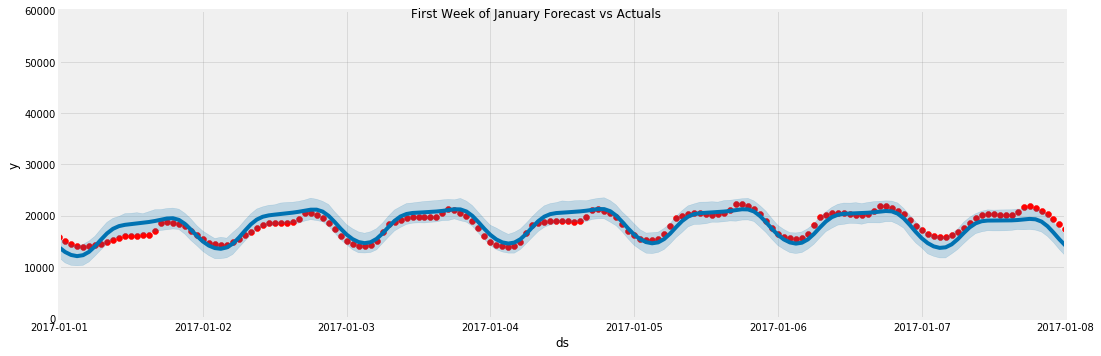

In [102]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(test.index[0], upper=test.index[(24*7)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

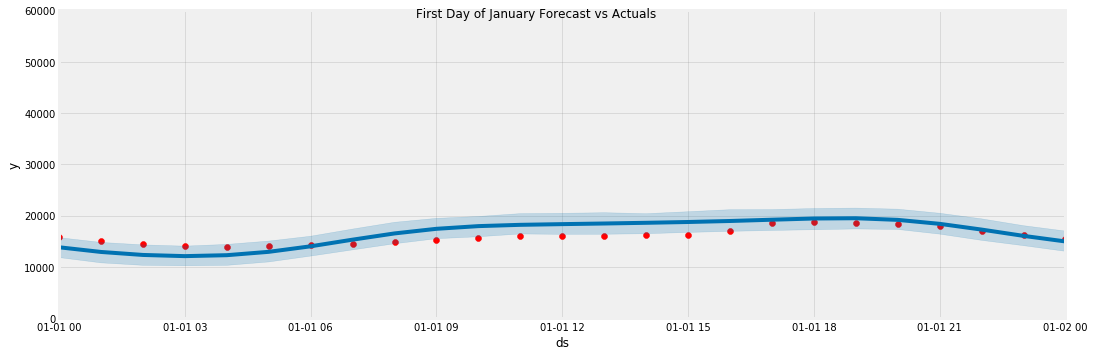

In [103]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(test.index[0], upper=test.index[(24)])
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Day of January Forecast vs Actuals')

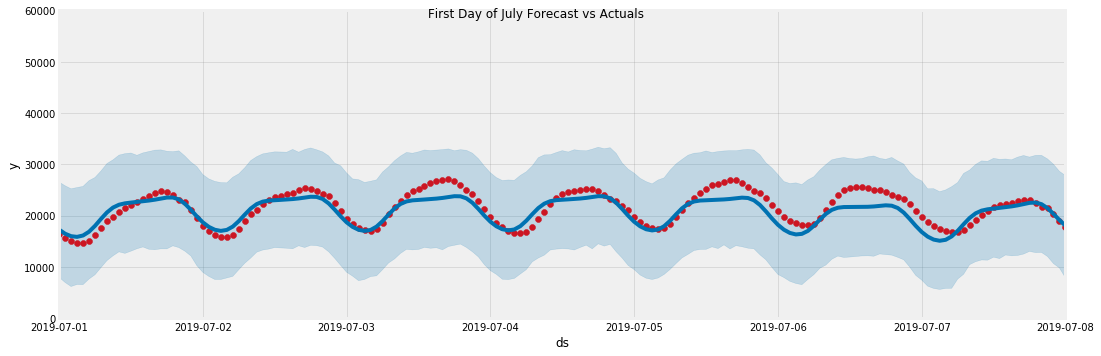

In [110]:
import datetime
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test[target], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(lower=datetime.datetime(2019, 7, 1), upper=datetime.datetime(2019, 7, 8))
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Day of July Forecast vs Actuals')

In [104]:
mean_squared_error(y_true=test[target],
                   y_pred=test_fcst['yhat'])

3223318.9947333527

In [105]:
mean_absolute_error(y_true=test[target],
                   y_pred=test_fcst['yhat'])

1383.488381728003

In [106]:
mean_absolute_percentage_error(y_true=test[target],
                   y_pred=test_fcst['yhat'])

7.5595643175386

In [112]:
symmetric_mape(test[target],
                   test_fcst['yhat'])

0.0